In this notebook, I aim to roll through an analysis across a few patients which can easily be extended for all of the  patients in your cohort. To do so, we will use the pre-processing functions that are written out more explicitly in the step-by-step notebooks. 

**This is the notebook you should copy and edit for your own actual analyses**

======================================================================================================================

These are magics that provide certain functionality. Specifically, if you edit functions that are called in this notebook, the functions are reloaded so the changes propagate here without needing to reload the notebook.


In [1]:
import sys
sys.path.insert(0, '/Users/gelana.tostaeva/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Documents/GitHub/LFPAnalysis_GT/')

from LFPAnalysis_GT import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 
import scipy

# I only want to see warnings once
warnings.filterwarnings('ignore')

Note: If you have installed the LFPAnalysis package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

## Pre-process (run 1x): 

In the pre-processing functions below, we: 

1. load the raw data (either a .edf file or a folder of .nlx files) into mne objects for use with the mne toolbox: https://mne.tools/stable/index.html.

2. load the localized electrode names from the .csv or .xlsx file listing their MNI coordinates into the mne object

3. filter and resample as necessary

4. re-reference 

In [27]:
subj_ids = ['MS038']
subj_sites = ['MSSM']
subj_formats = ['nlx']
                
base_dir = f'/Users/gelana.tostaeva/Documents/PhD/SocialNav/'
source_dir = f'/Users/gelana.tostaeva/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Sinai_iEEG_data/'


In [31]:
load_preproc_data = True
load_reref_data = False

In [35]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}, in {format}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{source_dir}{subj_id}/LFP/SocialNav/nlx'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{source_dir}{subj_id}/LFP/SocialNav/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    elec_path = f'{source_dir}/{subj_id}/anat/'
    
    # Check if path exists for saving, and if not, make it
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one, so grab it with the zero-index 
    elec_file = elec_files[0]
    
    if load_preproc_data:
        mne_data = mne.io.Raw(f'{save_path}raw_ieeg.fif', preload=True)
        
    else:
        # Make MNE file
        mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                 elec_path=elec_file,
                                                 format=format,
                                                 return_data=True,
                                                 site=site,
                                                 check_bad=False) # changed this to not annotate anything as bad 

        # Save this data so that you don't need this step again:
        mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)


Working on subj MS038, in nlx
Opening raw data file /Users/gelana.tostaeva/Documents/PhD/SocialNav//preproc/MS038/LFP/nlx/raw_ieeg.fif...


FileNotFoundError: fname does not exist: "/Users/gelana.tostaeva/Documents/PhD/SocialNav/preproc/MS038/LFP/nlx/raw_ieeg.fif"

## Re-reference the data (default=bipolar): 

We re-reference the data to get rid of shared noise, cleaning the data to leave what we assume is local biological activity. 

In [8]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    
    if load_reref_data:
        mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
    else:
        # Re-reference neural data
        mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                  elec_path=elec_file, 
                                                  method='bipolar', 
                                                  site=site)

        # Save this data so that you don't need this step again:
        mne_data_reref.save(f'{save_path}/ieeg_bp.fif', overwrite=True)

    # Should also save out re-referenced elec_file: 
    elec_data = lfp_preprocess_utils.load_elec(elec_file)
    anode_list = [x.split('-')[0] for x in mne_data_reref.ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])

    # Add region to the data frame 

    manual_col = [col for col in elec_df.columns if 'manual' in col.lower()][0]
    all_regions = [] 
    for chan_name in elec_df.label.unique():
        elec_region = analysis_utils.select_rois_picks(elec_df, chan_name, manual_col=manual_col)
        all_regions.append(elec_region) 

    elec_df['SNT_region'] = all_regions
    elec_df['hemisphere'] = elec_df.label.apply(lambda x: x[0])

    elec_df.to_csv(f'{save_path}/labels_bp', index=False)

Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS038/LFP//ieeg_bp.fif...
    Range : 0 ... 1346218 =      0.000 ...  2692.436 secs
Ready.
Reading 0 ... 1346218  =      0.000 ...  2692.436 secs...


 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

## NOW look at the data to manually remove channels: 

After bipolar referencing: 

In [10]:
%matplotlib notebook 

In [13]:
# Scroll up/down and left/right using your keyboard. CLICK on a channel to turn it 'grey' and mark as a 'bad' channel. 
# If you click a grey channel again it will unmark it. 

mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
fig = mne_data_reref.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data_reref._data.max()/30
                     )

Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS038/LFP//ieeg_bp.fif...
    Range : 0 ... 1346218 =      0.000 ...  2692.436 secs
Ready.
Reading 0 ... 1346218  =      0.000 ...  2692.436 secs...
Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>

In [14]:
# ALSO look at the power spectra! 
# You can click on channels here to identify them, and go back to the viz above to mark them as noise if need be

mne_data_reref.compute_psd().plot()

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data

Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 

First, you may need to MANUALLY clean the photodiode signal if the recording quality is poor. Load it, plot it, and try to isolate/amplify the pulses. 

In [ ]:
# subj_id = 'MS015'
# temp_diode = photodiode_dict[subj_id][0]._data[0, :]
# temp_diode[900000:] = np.nanmin(temp_diode)
# photodiode_dict[subj_id][0]._data = temp_diod

In [84]:
event_list = ['decision', 'narration', 'blank']
ts = {f'{x}': [] for x in event_list}
t = []
all_times = []
decision_times = []
beh_ts = []

behav_path = f'{base_dir}/data/{subj_id}/raw/behav/'
log_file = glob(f'{behav_path}/*.log')[0]

with open(log_file, 'r') as fobj:
    for ix, line in enumerate(fobj.readlines()):
        line = line.replace('\r', '')
        tokens = line[:-1].split('\t')

        t.append(tokens[1])
        # Extracting key press times for narrative trials
        if tokens[1] == 'DATA ':
            if ('Keypress: space' in tokens[2]):
                ts['narration'].append(float(tokens[0]))
                all_times.append(float(tokens[0]))

        # Extracting photodiode time stamps from log file
        if tokens[1] =='EXP ':
            # Grab photodiode timestamp
            if tokens[2][0:10] =='photodiode':
                if 'white.png' in tokens[2]:
                    beh_ts.append(float(tokens[0]))

behavior_df = pd.read_excel(glob(f'{behav_path}/*.xlsx')[0])

# Extracting photodiode timestamps from log file
response_df = behavior_df[behavior_df['photodiode'] == 'white.png']

# Extracting key press times for choice responses
response_ts = response_df['key_resp.rt_mean']
missing_responses = list((np.where(response_df['key_resp.keys_raw'].isna())[0]))

print(str(len(missing_responses)) + ' responses are missing')

ts['decision'] = beh_ts + response_ts
for idx, value in response_ts.items():
    if value < 8.5:
        ts['blank'].append(1 + ts['decision'][idx])

print(str(len(ts['blank'])) + ' blank trails')
ts['decision'] = ts['decision'].dropna().to_list()

beh_ts = np.array(beh_ts)
print(f'There are {len(beh_ts)} behav syncs detected')
narration_times = ts['narration']

# removing narrative trials with fast response time (<1s)
all_times = all_times + ts['decision']
all_times.sort()

response_times = [x-y for (x,y) in 
                  zip(all_times[1:], all_times[:-1])]
short_response_times = np.where(np.array(response_times)<2)
short_response_times = [x+1 for x in short_response_times][0]

fast_responses = [all_times[x] for x in short_response_times]

for response in fast_responses:
    del narration_times[narration_times.index(response)]

ts['narration'] = narration_times

# Synchronize to the photodiode or whatever your neural sync signal is
photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)

39 responses are missing
7 blank trails
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS038/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 9114543 =      0.000 ...  4557.271 secs
Ready.
Reading 0 ... 9114543  =      0.000 ...  4557.271 secs...


In [38]:
photodiode_data._data = photodiode_data._data[0,:6614544]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [85]:
photodiode_data.filter(l_freq=1.0, h_freq=None, picks='photodiode')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


<Raw | photodiode.fif, 1 x 9114544 (4557.3 s), ~69.5 MB, data loaded>

In [88]:
photodiode_data.filter(l_freq=None, h_freq=50, picks='photodiode')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 529 samples (0.265 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


<Raw | photodiode.fif, 1 x 9114544 (4557.3 s), ~69.5 MB, data loaded>

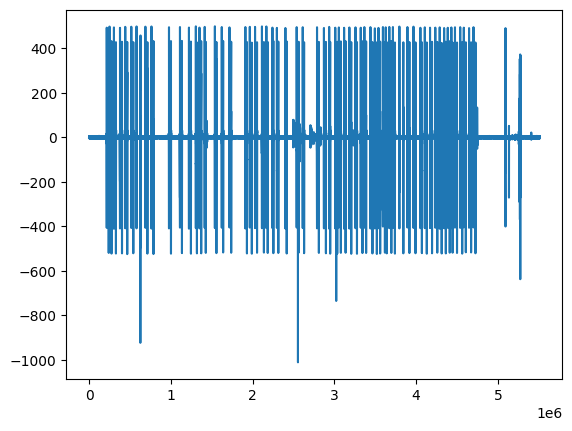

In [100]:
plt.plot(photodiode_data._data[0,600000:6114544])

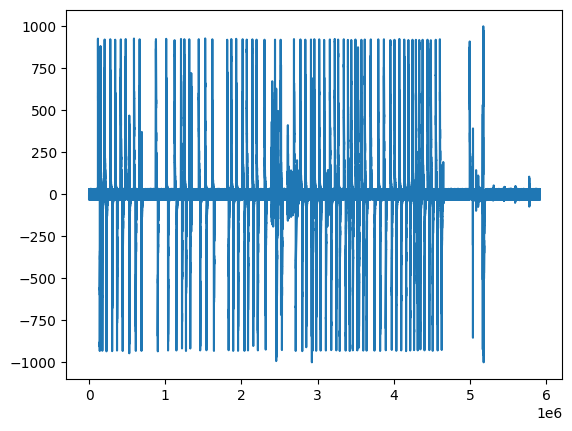

In [68]:
plt.plot(photodiode_data._data[700000:])

In [108]:
smoothSize=15
windSize=20
height=7.5

sig = np.squeeze(sync_utils.moving_average(photodiode_data._data, n=smoothSize))
timestamp = np.squeeze(np.arange(len(sig))/photodiode_data.info['sfreq'])
sig = scipy.stats.zscore(sig)
trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger

neural_ts = timestamp[trig_ix]
neural_ts = np.array(neural_ts)
len(neural_ts)

114

In [107]:
slopes

array([1.00266116, 1.01762177, 1.03153099, 1.04467054, 1.05649114,
       1.06733206, 1.07664447, 1.0844255 , 1.09045726, 1.09433331,
       1.09567232, 1.09478679, 1.09161285, 1.08640163, 1.07945755,
       1.0703534 , 1.05922453, 1.04578975, 1.0358933 , 1.02249337])

In [109]:
nwin = len(neural_ts) - len(beh_ts)
rvals = []
slopes = [] 
offsets = []
for i in range(nwin+1):
    slope, offset, rval = sync_utils.sync_matched_pulses(np.array(beh_ts), neural_ts[i:len(beh_ts)+i])
    rvals.append(rval)
    slopes.append(slope)
    offsets.append(offset)
rvals = np.array(rvals)
offsets = np.array(offsets)
slopes = np.array(slopes)

# get the best slope and offset
rvals, slopes, offsets
np.argmax(rvals)

slope=slopes[np.argmax(rvals)]
offset=offsets[np.argmax(rvals)]
slope, offset

(1.0457903900431695, -757.9746088331156)

In [25]:
sig = np.squeeze(sync_utils.moving_average(photodiode_data._data, n=smoothSize))
timestamp = np.squeeze(np.arange(len(sig))/photodiode_data.info['sfreq'])
sig = scipy.stats.zscore(sig)
trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger

neural_ts = timestamp[trig_ix]
neural_ts = np.array(neural_ts)

NameError: name 'smoothSize' is not defined

In [24]:
slopes = {f'{x}': [] for x in subj_ids}
offsets = {f'{x}': [] for x in subj_ids}

for subj_id in subj_ids: 
    
    event_list = ['decision', 'narration', 'blank']
    ts = {f'{x}': [] for x in event_list}
    t = []
    all_times = []
    decision_times = []
    beh_ts = []

    behav_path = f'{base_dir}/data/{subj_id}/raw/behav/'
    log_file = glob(f'{behav_path}/*.log')[0]
    
    with open(log_file, 'r') as fobj:
        for ix, line in enumerate(fobj.readlines()):
            line = line.replace('\r', '')
            tokens = line[:-1].split('\t')

            t.append(tokens[1])
            # Extracting key press times for narrative trials
            if tokens[1] == 'DATA ':
                if ('Keypress: space' in tokens[2]):
                    ts['narration'].append(float(tokens[0]))
                    all_times.append(float(tokens[0]))

            # Extracting photodiode time stamps from log file
            if tokens[1] =='EXP ':
                # Grab photodiode timestamp
                if tokens[2][0:10] =='photodiode':
                    if 'white.png' in tokens[2]:
                        beh_ts.append(float(tokens[0]))

    behavior_df = pd.read_excel(glob(f'{behav_path}/*.xlsx')[0])
    
    # Extracting photodiode timestamps from log file
    response_df = behavior_df[behavior_df['photodiode'] == 'white.png']

    # Extracting key press times for choice responses
    response_ts = response_df['key_resp.rt_mean']
    missing_responses = list((np.where(response_df['key_resp.keys_raw'].isna())[0]))
    
    print(str(len(missing_responses)) + ' responses are missing')

    ts['decision'] = beh_ts + response_ts
    for idx, value in response_ts.items():
        if value < 8.5:
            ts['blank'].append(1 + ts['decision'][idx])

    print(str(len(ts['blank'])) + ' blank trails')
    ts['decision'] = ts['decision'].dropna().to_list()

    beh_ts = np.array(beh_ts)
    print(f'There are {len(beh_ts)} behav syncs detected')
    narration_times = ts['narration']

    # removing narrative trials with fast response time (<1s)
    all_times = all_times + ts['decision']
    all_times.sort()
    
    response_times = [x-y for (x,y) in 
                      zip(all_times[1:], all_times[:-1])]
    short_response_times = np.where(np.array(response_times)<2)
    short_response_times = [x+1 for x in short_response_times][0]

    fast_responses = [all_times[x] for x in short_response_times]
    
    for response in fast_responses:
        del narration_times[narration_times.index(response)]

    ts['narration'] = narration_times
    
    # Synchronize to the photodiode or whatever your neural sync signal is
    photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
    
    try:
        slope, offset = sync_utils.synchronize_data(beh_ts, 
                            photodiode_data, 
                            smoothSize=11, windSize=15,
                            height=0.8)
    except IndexError:
        print('If this is failing, mess around with the height parameter - it could be too strict, or too lenient')
        

    print(slope)
    print(offset)
    slopes[subj_id].append(slope)
    offsets[subj_id].append(offset)

39 responses are missing
7 blank trails
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS038/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 9114543 =      0.000 ...  4557.271 secs
Ready.
Reading 0 ... 9114543  =      0.000 ...  4557.271 secs...
170 blocks
..........................................................................................................................................................................

found matches for 0 of 2552 pulses
fast sync failed - running robust sync now
.................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyError: 'beh_timestamps'

 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

## Load your behavioral data

You probably have a separate notebook for processing the behavioral data for your task. Load the processed dataframe here:

In [10]:
behav_data = pd.read_csv(f'{load_path}/sample_beh.csv')

In [12]:
behav_data.head(5)[['trials', 'feedback_start', 'baseline_start']]

,trials,feedback_start,baseline_start
0,1,243.239158,244.929025
1,2,248.344187,250.043187
2,3,254.083059,255.790670
3,4,258.148220,259.838892
4,5,261.943712,263.620631


## Make epochs

Make epochs and remove IEDs. Currently just doing this for one example period - when subjects receive feedback. 

Notes: 

- I also segment a baseline period for every event of interest. 

- I apply a buffer period of 1.0 seconds - this will be helpful when we compute spectrograms later. 

- The IED count for every channel is added to the epoch metadata

(I'm a little dumb, so my baseline is a fixation cross AFTER the trial, rather than before. A bit silly if you ask me.) 

In [13]:
# set some windows of interest 

buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

IED_args = {'peak_thresh':5,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

# evs = ['gamble_start', 'feedback_start', 'baseline_start']
evs = {'feedback_start': [-0.5, 1.5],
       'baseline_start': [0, 0.75]}

load_path = '/hpc/users/qasims01/resources/LFPAnalysis/data'

# add behavioral times of interest 
# for subj_id in subj_ids:
    # Set paths
#     load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/Day1'
#     save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/Day1'

epochs_all_evs = {f'{x}': np.nan for x in evs}
for event in evs.keys():
    pre = evs[event][0]
    post = evs[event][1]
    fixed_baseline = None
#     behav_times = learn_df[(learn_df.participant==subj_id)][event]
    behav_times = behav_data[event]

    # THE following function will now SAVE out dataframes that indicate IED and artifact time points in your data

    epochs = lfp_preprocess_utils.make_epochs(load_path=f'{load_path}/sample_ieeg_bp.fif', 
                                              slope=slope, offset=offset, 
                                              behav_name=event, behav_times=behav_times,
                                              ev_start_s=pre, ev_end_s=post, buf_s=1, downsamp_factor=None, IED_args=IED_args, detrend=0)


    epochs_all_evs[event] = epochs
    epochs_all_evs[event].save(f'{load_path}/sample_{event}-epo.fif', overwrite=True)


Opening raw data file /hpc/users/qasims01/resources/LFPAnalysis/data/sample_ieeg_bp.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 2001 original time points ...
0 bad epochs dropped
Opening raw data file /hpc/users/qasims01/resources/LFPAnalysis/data/sample_ieeg_bp.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.5s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped


 - epochs_all_evs: dictionary containing the epochs for all of your subjects' re-referenced data

Plot and examine the epochs if you'd like:

In [73]:
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

In [74]:
# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

## Where do I go from here? 

At this point, you've successfuly pre-processed your iEEG data and sliced it around your timepoints of interest. These epochs are going to be the currency for many of your subsequent analyses, so make sure you TRUST THEM before proceeding to the other notebooks for analyses. 

From here, you can move on to the:

1. FOOOF: a notebook for computing power-spectra across trials and fitting their peaks 

2. TFRPlotsAndStatistics: a notebook for computing time-frequency spectra (trial-level), and computing several different statistics or simply saving the data out in dataframes. 

3. OscillationDetection(BOSC): a notebook for computing sliding burst detection and saving the data out in dataframes 

4. TimeResolvedRegression: a notebook for computing regression analysis at each timepoint of a timeseries. TFR-extracted band power is used as example. 

5. ConnectivityAnalysis: a notebook for computing different synchrony measures between electrodes. 